In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob
import os

In [2]:
from scipy.signal import butter, sosfilt, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [3]:
# FFT and Filtering parameters
band_freq_min=2000
band_freq_max=10500
windowlength=512 # also equals to NFFT
N_overlap=400 # Overlap length in STFT 
SPL_switch=1 # Switcher, wheter to use Absolute or Log values for Spund pressure level 

In [4]:
path='C:/Users/dgnhk_000/Downloads/ARSU 2017/20170330_Uhu/Waldschnepfe_recog/positives/'

Read the first data, to get Spectrogram dimensions

In [6]:
Syy=np.zeros([257,395])
Sxx=Syy.reshape(1,257*395)
Sxx.shape
# Parameter for applying 20 %  cyclic shift to Spectrogram for Augmentation purpose
shift_amount=int(0.2*Syy.shape[1])
shift_amount

79

In [7]:
AA=np.zeros([462,Syy.shape[0]*Syy.shape[1]])

In [8]:
path='C:/Users/dgnhk_000/Downloads/ARSU 2017/20170330_Uhu/Waldschnepfe_recog/positives/'

In [9]:
count=0
for audioFile in glob.glob(os.path.join(path, '*.wav')):
    (sig, rate) = librosa.load(audioFile, sr=22050, mono=True)
    filtered=butter_bandpass_filter(sig, band_freq_min, band_freq_max, fs=rate, order=5)
    f, t, Syy = signal.stft(filtered,fs=rate,window='hann',noverlap=N_overlap,nfft=windowlength,nperseg=windowlength)
    Syy=abs(Syy)
    if SPL_switch == 1: Syy=20*np.log10(Syy/0.00002)
    # Apply shift 
    for i in range(5):
        N_shift=i*shift_amount
        S=np.roll(Syy, N_shift, axis=1)
        S_flat=S.reshape(1,Syy.shape[0]*Syy.shape[1])# Flattening the spectrogram
        AA[count,:]=S_flat
        count+=1
countPositives=count

In [10]:
countPositives

170

In [12]:
path='C:/Users/dgnhk_000/Downloads/ARSU 2017/20170330_Uhu/Waldschnepfe_recog/negatives/'

In [13]:
for audioFile in glob.glob(os.path.join(path, '*.wav')):
    (sig, rate) = librosa.load(audioFile, sr=22050, mono=True)
    filtered=butter_bandpass_filter(sig, band_freq_min, band_freq_max, fs=rate, order=5)
    f, t, Syy = signal.stft(filtered,fs=rate,window='hann',noverlap=N_overlap,nfft=windowlength,nperseg=windowlength)
    Syy=abs(Syy)
    if SPL_switch == 1: Syy=20*np.log10(Syy/0.00002)
    
    S_flat=Syy.reshape(1,Syy.shape[0]*Syy.shape[1])# Flattening the spectrogram
    AA[count,:]=S_flat
    count+=1
    
countTotal=count

In [14]:
countTotal

462

In [15]:
y_data=np.zeros([countTotal,1])

In [16]:
y_data[0:countPositives]=1

In [17]:
data=np.zeros([462,257*395+1])

In [18]:
data[:,0]=y_data.T

In [19]:
data[:,1:]=AA

In [128]:
# data2=data[:100,:100000]

In [20]:
path='C:/Users/dgnhk_000/Downloads/ARSU 2017/20170330_Uhu/Waldschnepfe_recog/'
filename=path+'train.csv'

In [21]:
np.savetxt(filename,data,delimiter=',')

In [135]:
# pd.DataFrame(data).to_csv(filename,header=None,index=None)

Text(0.5, 0, 'Time [sec]')

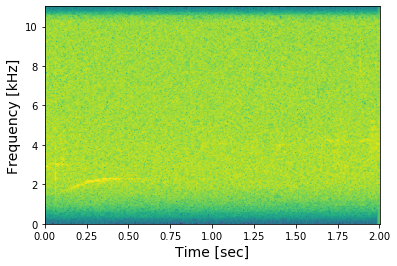

In [22]:
plt.pcolormesh(t[:],f[:]/1e3,Syy[:,:])
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.xlabel('Time [sec]',fontsize=14)

In [25]:
S=np.roll(Syy, 2*79, axis=1)

Text(0.5, 0, 'Time [sec]')

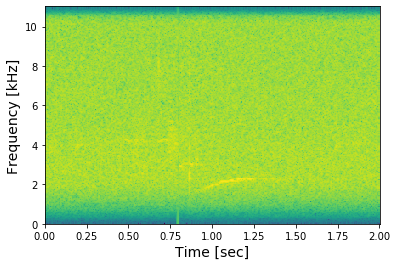

In [26]:
plt.pcolormesh(t[:],f[:]/1e3,S[:,:])
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.xlabel('Time [sec]',fontsize=14)

Template Matching auf Abschnitte mit 1000 Sekunden Zeit Intervalle

Find the positions of the maximas <br> which are above a THRESHOLD

In [27]:
del(data,AA)